In [1]:
import pandas as pd
from pprint import pprint
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import cross_val_score, train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn import linear_model, cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn import pipeline
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score

from xgboost import XGBClassifier as xgb
import string
from sklearn.pipeline import TransformerMixin, FeatureUnion, make_pipeline, make_union, Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.preprocessing import Normalizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline

from nltk.tokenize import word_tokenize #, PunktSentenceTokenizer, 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from gensim import corpora, models, similarities, matutils
import time, random, operator

In [2]:
data = pd.read_csv('/Users/derekupdegraff/Metis_Class/octtext.csv', names = ['year', 'text'])
data.head()

,year,text
0,1600,215 23 ) r Bruno Ryvcs gives a remarkable inst...
1,1600,"AmohinÃ¡base el perro, y, dando ladridos y au..."
2,1600,"Sate deep remorle of Confcience, all bcfprenc ..."
3,1600,"Lorinser, I have added occasional notes of my ..."
4,1600,"This is a long process towards baptism, and se..."


"Confcience" in document 2 is a bit of a red flag and indicative of a larger issue with the data; old-style long-S's are often transcribed as f's, making it far easier than it should be to sort.

So I looked through the most common words in the English language, found those with s's in them, and eliminated any document that had an s-f transposition there.

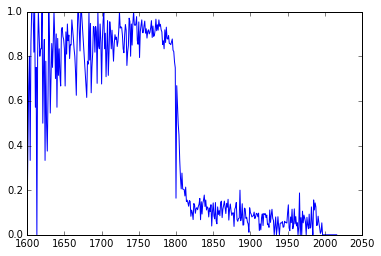

In [3]:
commonbads = ['waf','thif','faid', 'itf', "it'f",'ufe','thofe','moft','juft','fentence','fhow','fmall']

def checkbads(mytext):
    tlower = mytext.lower()
    count = 0
    for word in commonbads:
        count = count + tlower.count(word)
    lwords = len(tlower.split())
    return count/lwords
    
data['bads'] = (data.text.apply(checkbads,1)> 0)
avsb = data[['bads','year']].groupby("year", as_index = False).mean()
plt.plot(avsb.year, avsb.bads)

This is almost all documents until about 1800 -- a big problem. I'll remove them.

In [4]:
data = data[data.bads == 0]
data.drop('bads',axis = 1, inplace = True)
data.head()


,year,text
0,1600,215 23 ) r Bruno Ryvcs gives a remarkable inst...
1,1600,"AmohinÃ¡base el perro, y, dando ladridos y au..."
3,1600,"Lorinser, I have added occasional notes of my ..."
4,1600,"This is a long process towards baptism, and se..."
5,1600,Cap.4. Curferrum tadum acquirit contrariam ver...


In [5]:
def getdecade(year):
    return int(year/10)*10

data['decade'] = data.year.apply(getdecade,1)

data.head()

,year,text,decade
0,1600,215 23 ) r Bruno Ryvcs gives a remarkable inst...,1600
1,1600,"AmohinÃ¡base el perro, y, dando ladridos y au...",1600
3,1600,"Lorinser, I have added occasional notes of my ...",1600
4,1600,"This is a long process towards baptism, and se...",1600
5,1600,Cap.4. Curferrum tadum acquirit contrariam ver...,1600


My data set is unbalanced, so I'm looking to balance it on a subset of decades with enough documents.
This will keep things even for fair prediction, as well as saving computational resources that would otherwise be used predicting major decades.

First this means filtering out sparse decades to focus on a densely populated region, then evening the samples there.

In [6]:
data.decade.value_counts()

1900    8358
1940    2448
1820    2266
1810    1993
1800    1499
1830    1099
1910     933
1890     835
1870     765
1880     752
1850     732
1840     689
1860     622
1920     512
1950     499
1970     445
1990     440
1960     272
1930     257
1980     255
1790     223
1780     102
1770      55
1760      54
1730      43
1700      43
2010      40
1750      39
1710      36
1680      32
1720      31
1740      30
1650      28
1690      26
1630      21
1640      20
1620      17
1600      17
1660      15
1610      11
1670       5
2000       1
Name: decade, dtype: int64

In [7]:
# 1800-1970 is well populated
data = data[data.decade > 1790]
data = data[data.decade < 1980]
data.decade.value_counts()

1900    8358
1940    2448
1820    2266
1810    1993
1800    1499
1830    1099
1910     933
1890     835
1870     765
1880     752
1850     732
1840     689
1860     622
1920     512
1950     499
1970     445
1960     272
1930     257
Name: decade, dtype: int64

In [8]:
min(list(data['decade'].value_counts()))

257

In [9]:
decades = list(data.decade.unique())
    
def rebalance(dataframe, column, number_per_val = 'min'):
    if number_per_val == 'min':
        number_per_val = min(list(dataframe[column].value_counts()))
    columns = list(dataframe[column].unique())
    column_chunks = []
    for value in columns:
        data_column = dataframe[dataframe[column] == value] 
        data_column_sub, junk = train_test_split(data_column, test_size = 1 - (number_per_val/len(data_column)))
        column_chunks.append(data_column_sub)
    return pd.concat(column_chunks)

In [10]:
data = rebalance(data,'decade')
data.decade.value_counts()

1970    257
1940    257
1820    257
1840    257
1860    257
1880    257
1900    257
1920    257
1800    257
1810    257
1830    257
1850    257
1870    257
1910    257
1930    257
1950    256
1890    256
1960    256
Name: decade, dtype: int64

In [11]:
data = shuffle(data)
data.head(50)

,year,text,decade
34676,1970,"In the summer of 1869, I was in Florence, Ita...",1970
20544,1900,His present position in Italy as a poet and p...,1900
34818,1973,The Monthly will be glad to receive new public...,1970
34590,1967,record. Grid resolution of graph paper indicat...,1960
16510,1854,"of these methods of treatment, and the conditi...",1850
17349,1866,"called a Dissyllable; as, truthful: one which ...",1860
10418,1815,"I believe, that the effusion of fluid from th...",1810
16887,1859,"Natural History, considered in reference to th...",1850
18380,1878,Common-wealth v. Pease . V. Peck v. Pemberto...,1870
29653,1912,4. Inner Forces. The internal or inner forces ...,1910


In [12]:
# SUBSET FOR SPEED
# data_sub, junk = train_test_split(data, test_size = 0.9)
# data_sub = rebalance(data,'decade', number_per_val = 40)
data_sub = data
data_sub.decade.value_counts()

1970    257
1940    257
1820    257
1840    257
1860    257
1880    257
1900    257
1920    257
1800    257
1810    257
1830    257
1850    257
1870    257
1910    257
1930    257
1950    256
1890    256
1960    256
Name: decade, dtype: int64

In [13]:
# Building test and train sets
othercols = list(data_sub.columns)
othercols.remove('text')
othercols

X, y = data_sub['text'], data_sub[['year','decade']]

Next, I clean years from my data set to avoid fitting on that -- documents mentioning "1974" are probably not going to be from the 1820s, and that's not fair to include in the model.

In [14]:
badstrings = [str(c) for c in list(range(1000,2016))]
replacedict = {}
for string in badstrings:
    for c in ' -,;()[]':
        replacedict[string + c] = c
        replacedict[c+ string] = c

def numberscrub(mytext):
    for key in replacedict.keys():
        mytext = mytext.replace(key, replacedict[key])
    return mytext

X = X.apply(numberscrub,1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

def subset(mytext, minlen = 100):
    return mytext[:mytext[minlen:].find('.') + minlen]

X_train_short = X_test.apply(subset, 1)
X_test_short = X_test.apply(subset, 1)

Next I build a model to predict the year of text. 

Because I'm going to be doing a lot of cross validation checking, I want to transform my data just once, as opposed to doing it every time I build a different model.

In [16]:
def fold_transform(X, y, nfolds, mypipe, random_state = 42):
    X_trainfolds, X_testfolds, y_trainfolds, y_testfolds = [], [], [], []
    blanks = np.zeros(len(X))
    for i in range(nfolds):
        blanks[:round(i*len(X)/nfolds)] = blanks[:round(i*len(X)/nfolds)] + 1
    shuffled = shuffle(blanks, random_state = random_state)
    for i in range(nfolds):
        X_trainfolds.append(mypipe.fit_transform(X[shuffled != i]))
        X_testfolds.append(mypipe.transform(X[shuffled == i]))
        y_trainfolds.append(y[shuffled != i])
        y_testfolds.append(y[shuffled == i])
        
    return X_trainfolds, X_testfolds, y_trainfolds, y_testfolds

In [17]:
def makepipe(params, model = None):
    [ngram_ceil, stop_words, lowercase, svd] = params
    if model == None:
        if svd in [0,None]:
            return Pipeline([('vect', CountVectorizer(ngram_range=(1, ngram_ceil), lowercase = lowercase, stop_words = stop_words)),
                    ('tfidf', TfidfTransformer()),])
        elif type(svd) == int:
            return Pipeline([('vect', CountVectorizer(ngram_range=(1, ngram_ceil), lowercase = lowercase, stop_words = stop_words)),
                    ('tfidf', TfidfTransformer()),('svd', TruncatedSVD(n_components = svd)),])
    else:
        if svd in [0,None]:
            return Pipeline([('vect', CountVectorizer(ngram_range=(1, ngram_ceil), lowercase = lowercase, stop_words = stop_words)),
                    ('tfidf', TfidfTransformer()),('model', model)])
        elif type(svd) == int:
            return Pipeline([('vect', CountVectorizer(ngram_range=(1, ngram_ceil), lowercase = lowercase, stop_words = stop_words)),
                    ('tfidf', TfidfTransformer()),('svd', TruncatedSVD(n_components = svd)),('model', model)])

In [18]:
t0 = time.time()
X_trainfolds, X_testfolds, y_trainfolds, y_testfolds = {},{},{},{}
# ngram_ceils, stop_wordses, lowercases, svds = [1], ['english'], [True], [None]# for quick testing
ngram_ceils, stop_wordses, lowercases, svds = [1,2], [None], [False], [None,100]


for ngram_ceil in ngram_ceils:
    if ngram_ceil not in y_testfolds.keys():
        X_trainfolds[ngram_ceil], X_testfolds[ngram_ceil], y_trainfolds[ngram_ceil], y_testfolds[ngram_ceil] = {},{},{},{}
    for stop_words in stop_wordses:
        if stop_words not in y_testfolds[ngram_ceil].keys():
            X_trainfolds[ngram_ceil][stop_words], X_testfolds[ngram_ceil][stop_words] = {},{}
            y_trainfolds[ngram_ceil][stop_words], y_testfolds[ngram_ceil][stop_words] = {},{}
        for lowercase in lowercases:
            if lowercase not in y_testfolds[ngram_ceil][stop_words].keys():
                X_trainfolds[ngram_ceil][stop_words][lowercase], X_testfolds[ngram_ceil][stop_words][lowercase] = {},{}
                y_trainfolds[ngram_ceil][stop_words][lowercase], y_testfolds[ngram_ceil][stop_words][lowercase] = {},{}
            for svd in svds:
                if svd not in y_testfolds[ngram_ceil][stop_words][lowercase].keys():
                    Xtr, Xte, ytr, yte = fold_transform(X_train, y_train, 5, 
                                                        makepipe([ngram_ceil, stop_words, lowercase, svd]),
                                                        random_state = 42)
                    X_trainfolds[ngram_ceil][stop_words][lowercase][svd] = Xtr
                    X_testfolds[ngram_ceil][stop_words][lowercase][svd] = Xte
                    y_trainfolds[ngram_ceil][stop_words][lowercase][svd] = ytr
                    y_testfolds[ngram_ceil][stop_words][lowercase][svd] = yte
print('Process took ' + str(time.time()-t0) + ' seconds.')

Process took 3394.0058150291443 seconds.


In [19]:
t0 = time.time()
modelnames_reg = ['LinReg','Lasso','Ridge','ElasticNet','RF','XGB']
regression_models_outer = [LinearRegression(), Lasso(),Ridge(),ElasticNet(),rfr(),xgb(objective = 'reg:linear')]
regression_models_dict = {}
model_best_params = {}
for j in range(len(modelnames_reg)):
    t1 = time.time()
    regression_models_dict[modelnames_reg[j]] = regression_models_outer[j]
    model_best_score, model_best_type = -1000, 0
    for ngram_ceil in ngram_ceils:
        for stop_words in stop_wordses:
            for lowercase in lowercases:
                for svd in svds:
                    regression_models = [LinearRegression(), Lasso(),Ridge(),ElasticNet(),rfr(),xgb(objective = 'reg:linear')]
#                     regression_models = [LinearRegression(), Lasso(),Ridge(),ElasticNet(),rfr(),xgb(objective = 'reg:linear')]
                    #define these here so the models initialize differently
                    gosvd = 0
                    if (type(svd) == int):
                        gosvd = (svd > 0) + 0
                    model_iter = regression_models[j]
#                     model_fit = regression_models_[j]
                    scores = []
                    if ((j<4) + gosvd) > 0:# only run RF, XGB on SVD -- too slow for full feature set
                        for fold in range(5):
                            Xtr = X_trainfolds[ngram_ceil][stop_words][lowercase][svd][fold]
                            Xte = X_testfolds[ngram_ceil][stop_words][lowercase][svd][fold]
                            ytr = y_trainfolds[ngram_ceil][stop_words][lowercase][svd][fold]['year']
                            yte = y_testfolds[ngram_ceil][stop_words][lowercase][svd][fold]['year']
                            model_iter.fit(Xtr,ytr)
                            scores.append(r2_score(yte, model_iter.predict(Xte)))
                        currentscore = sum(scores)/len(scores)
                        if currentscore > model_best_score:
                            model_best_score, model_best_params[modelnames_reg[j]] = currentscore, [ngram_ceil, stop_words, lowercase, svd]

    [bngram_ceil, bstop_words, blowercase, bsvd] = model_best_params[modelnames_reg[j]]
    print(modelnames_reg[j] + ':\n')
    print('R2 Score: ' + str(model_best_score))
    print('Best ngram_ceil: ' + str(bngram_ceil))
    print('Best lowercase: ' + str(blowercase))
    print('Best stop_words: ' + str(bstop_words))
    print('Best svd: ' + str(bsvd) + '\n')
    print(str(time.time()-t1) + ' seconds to build model\n\n')
print(str(time.time()-t0) + ' seconds overall')

//anaconda/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinReg:

R2 Score: 0.746992098819
Best ngram_ceil: 2
Best lowercase: False
Best stop_words: None
Best svd: None

59.42421889305115 seconds to build model


Lasso:

R2 Score: 0.143738734633
Best ngram_ceil: 1
Best lowercase: False
Best stop_words: None
Best svd: 100

55.13739204406738 seconds to build model


Ridge:

R2 Score: 0.693983994357
Best ngram_ceil: 1
Best lowercase: False
Best stop_words: None
Best svd: None

41.95932197570801 seconds to build model


ElasticNet:

R2 Score: 0.0126334670951
Best ngram_ceil: 1
Best lowercase: False
Best stop_words: None
Best svd: 100

48.08889293670654 seconds to build model


RF:

R2 Score: 0.519873675102
Best ngram_ceil: 1
Best lowercase: False
Best stop_words: None
Best svd: 100

12.717246055603027 seconds to build model


XGB:

R2 Score: 0.266067422548
Best ngram_ceil: 1
Best lowercase: False
Best stop_words: None
Best svd: 100

2213.989958047867 seconds to build model


2431.3533461093903 seconds overall


In [20]:
t0 = time.time()
models_pipe_reg = {}
for key in modelnames_reg:
    innermodel = regression_models_dict[key]
    mymodel = makepipe(model_best_params[key], model = innermodel)
    mymodel.fit(X_train,y_train.year)
    predsyear = mymodel.predict(X_test)
    models_pipe_reg[key] = mymodel
    predsdec = np.floor(predsyear/10)*10
    print(key + ':\n')
    print('Correct Decade: ' + str(round((predsdec == y_test.decade).mean()*100,2)) + '%')
    print('R2: ' + str(r2_score(y_test.year,predsyear)) + '\n\n')
print(time.time()-t0)

LinReg:

Correct Decade: 19.54%
R2: 0.746655408563


Lasso:

Correct Decade: 5.84%
R2: 0.127009327326


Ridge:

Correct Decade: 15.0%
R2: 0.699379194112


ElasticNet:

Correct Decade: 5.34%
R2: 0.0125886545398


RF:

Correct Decade: 14.28%
R2: 0.544547171953


XGB:

Correct Decade: 14.28%
R2: 0.324885164557


449.2221682071686


In [21]:
truths = pd.DataFrame(data = X_test.copy(), columns = ['text'])
truths['predicted'] = models_pipe_reg['LinReg'].predict(X_test)
truths['actual'] = y_test.year.copy()
truths['decade'] = np.floor(np.asarray(truths.actual/10))*10
truths.head()

,text,predicted,actual,decade
19178,Sractised as a barrister in the Supreme Court ...,1892.117948,1888,1880.0
34729,She could see Mary Ellen's back as she climbe...,1910.889498,1971,1970.0
19432,"At the same time, as we have already indicated...",1889.945156,1891,1890.0
28415,"It is an enormous theatre, in which thousands...",1883.510386,1905,1900.0
32301,Numerous varieties of perfumes have long been...,1923.979403,1943,1940.0


In [22]:
decs = sorted(truths.decade.unique().tolist())
errdecs = []
for dec in decs:
    tdec = truths[truths.decade == dec]
    errdecs.append((np.square(tdec.actual - tdec.predicted).mean())**.5)

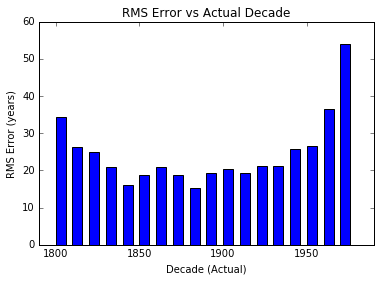

In [23]:
plt.bar(decs, errdecs, width = 6)
plt.xlim(1790,1990)
plt.title('RMS Error vs Actual Decade')
plt.xlabel('Decade (Actual)')
plt.ylabel('RMS Error (years)')

In [24]:
coefs = list(models_pipe_reg['LinReg'].named_steps['model'].coef_)
features = models_pipe_reg['LinReg'].named_steps['vect'].get_feature_names()[:]
coefdict = {}
for i in range(len(coefs)):
    coefdict[features[i]] = coefs[i]


In [70]:
asc_coefs = sorted(coefdict.items(), key=operator.itemgetter(1))
asc_coefs[:100]

[('which', -108.61921153735224),
 ('it', -89.10384126978569),
 ('every', -78.540683716086548),
 ('their', -75.150165476129146),
 ('till', -69.864465587647345),
 ('st', -68.72207568029674),
 ('tlie', -63.237485752952423),
 ('upon', -62.441289213836086),
 ('by', -60.753405656428825),
 ('And', -60.623268593220487),
 ('so', -59.560689734505381),
 ('therefore', -58.989313642421962),
 ('he', -58.765976371988444),
 ('the same', -57.720847307365489),
 ('same', -57.446219262670986),
 ('the said', -55.560121490594874),
 ('Mr', -55.078685339940826),
 ('being', -52.895537781053022),
 ('any thing', -52.557143193069301),
 ('est', -49.486670413527158),
 ('Av', -48.180218555390624),
 ('Elsa', -48.169456138044971),
 ('towards', -47.573781264763241),
 ('my', -46.945945980581499),
 ('yet', -45.396118452195097),
 ('thee', -44.629693312076903),
 ('them', -43.668370064163312),
 ('much', -43.166393035708943),
 ('Virgile', -43.154723086984689),
 ('very', -42.924336706323665),
 ('every thing', -42.828601950727

In [71]:
desc_coefs = sorted(coefdict.items(), key=operator.itemgetter(1), reverse = True)
desc_coefs[:100]

[('for', 105.813224363914),
 ('later', 91.614494267589293),
 ('in', 82.019920624560854),
 ('de', 79.084195142385823),
 ('area', 73.343194308302955),
 ('rÃ', 67.811546651362448),
 ('Act', 66.072664540844798),
 ('section', 63.562460553093324),
 ('The', 59.281289466122963),
 ('was', 56.614551895034417),
 ('come', 56.205075612576913),
 ('However', 56.073848224173638),
 ('life', 55.655400327875164),
 ('used', 54.784728166936624),
 ('control', 54.744523617735325),
 ('Kenan', 54.628662598805946),
 ('di', 53.504070904568138),
 ('In', 53.450577191400029),
 ('century', 53.276756166761736),
 ('today', 51.99502406969674),
 ('group', 51.801258168215149),
 ('fact that', 50.87535691978271),
 ('Mother', 49.655684510551922),
 ('Wagner', 49.49743170256756),
 ('material', 48.995675247018887),
 ('because of', 48.363488983156685),
 ('Illinois', 48.274878405715661),
 ('special', 48.019538808953044),
 ('toward', 47.615366248283586),
 ('Church', 47.306506279958349),
 ('lord de', 47.179584972176805),
 ('mm', 4

Looks like a lot of political stuff (democracy vs monarchy), science terms, and US vs British english spellings, as the latter's share of the english language corpus declines.

In [54]:
def printscores(words,mydict):
    for word in words:
        scores = []
        if word.lower() in mydict:
            scores.append(mydict[word.lower()])
        if word.upper() in mydict:
            scores.append(mydict[word.upper()])
        if word.capitalize() in mydict:
            scores.append(mydict[word.capitalize()])
        score = sum(scores)/max([len(scores),1])# returns zero if scores is empty
        print(word + ': ' + str(score))

In [84]:
old = ['lord','earl','duke','king','aether','ark','humour','colour','flavour']
new = ['federal', 'subcommittee','mayor','president','nuclear','oxygen','humor','color','flavor']

In [85]:
printscores(old,coefdict)
print()
printscores(new, coefdict)

lord: -13.8528646297
earl: -7.78696194796
duke: -8.80249508052
king: -2.40514336763
aether: -0.0735818023356
ark: -5.89658746189
humour: -7.07773791572
colour: -19.2913627267
flavour: -3.32091373335

federal: 19.2736618667
subcommittee: 15.6203634498
mayor: 1.19060745749
president: 10.1156412821
nuclear: 6.95767114573
oxygen: 5.57586088372
humor: 6.03971462223
color: 15.1040811773
flavor: 5.50997360966


In [41]:
examples = pd.DataFrame(data = old, columns = ['earlier'])
examples['later'] = new
examples

,earlier,later
0,lord,federal
1,earl,subcommittee
2,duke,mayor
3,king,president
4,aether,nuclear
5,ark,oxygen
6,humour,humor
7,colour,color
8,flavour,flavor
